# Analysis

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
import umap
import random
import matplotlib.cm as cm
import math
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## Loading in Data

In [2]:
# Load formatted data 
data = pd.read_csv("Formatted_Data.csv")
data.head()

,new_id,day,date,Anxious.morning,Anxious.afternoon,Anxious.night,gad7_total,month_start_date,month_end_date
0,1001_0,0,2016-05-11,NaN,NaN,NaN,5.0,2016-05-11,2016-06-07
1,1001_0,1,2016-05-12,NaN,NaN,NaN,5.0,2016-05-11,2016-06-07
2,1001_0,2,2016-05-13,NaN,NaN,NaN,5.0,2016-05-11,2016-06-07
3,1001_0,3,2016-05-14,NaN,NaN,NaN,5.0,2016-05-11,2016-06-07
4,1001_0,4,2016-05-15,NaN,NaN,NaN,5.0,2016-05-11,2016-06-07


In [3]:
# Find number of days per person-month 
measured_days = []
for individual in sorted(list(set(data['new_id']))):
    person_data = data[data['new_id']==individual]
    measured_days.append(len(person_data))
total_timepoints = min(measured_days)
total_timepoints

28

In [4]:
# Rebuild formatted data df 
total_array = []
for individual in sorted(list(set(data['new_id']))):
    person_array = []
    person_data = data[data['new_id']==individual]
    for time_point in range(total_timepoints):
        time_array = list(person_data[['Anxious.morning', 'Anxious.afternoon', 'Anxious.night']].iloc[time_point,:])
        time_array = [(data-1)/6.0 for data in time_array]
        person_array.append(time_array)
    total_array.append(person_array)
formatted_data=np.array(total_array)
formatted_data_removed_nans = np.nan_to_num(formatted_data, nan=-1)

In [5]:
# Find and bin GAD-7 for each person-month 
GAD_outcome = []
for i in list(sorted(set(data['new_id']))):
    person_data=data[data['new_id']==i]
    GAD_outcome.append(list(person_data['gad7_total'])[1])
GAD_outcome = np.array(GAD_outcome)
GAD_outcome_binned = []
for out in GAD_outcome:
    if out < 5:
        GAD_outcome_binned.append(0)
    elif out >=5 and out < 10:
        GAD_outcome_binned.append(1)
    elif out >=10 and out < 15:
        GAD_outcome_binned.append(2)
    else:
        GAD_outcome_binned.append(3)
GAD_outcome = np.nan_to_num(GAD_outcome, np.average(GAD_outcome))
GAD_outcome_binned = np.nan_to_num(GAD_outcome_binned, np.average(GAD_outcome_binned))

In [6]:
# Extract features from LSTM model's 3rd layer (the one with 3 nodes) for each person-month 
output_feature_df = pd.read_csv('output_LSTM_3_layer.csv')
output_feature = np.array(output_feature_df)
output_feature_df

,0,1,2
0,-0.706480,-7.862085e-04,-0.003209
1,-0.115320,-8.124102e-02,0.265431
2,-0.105543,-2.817863e-02,-0.507318
3,-0.835107,-3.306061e-07,-0.000020
4,-0.193251,-1.154037e-06,-0.000062
...,...,...,...
61,0.442759,-2.077148e-01,-0.586962
62,-0.147095,-3.865291e-02,0.247122
63,2.504017,9.284002e-03,-0.099583
64,2.119597,2.862381e-02,-0.243279


## UMAP Analysis

In [7]:
fit = umap.UMAP(random_state=0)
my_data = fit.fit_transform(output_feature)

In [8]:
# Find new features that data could be clustering on (e.g. percent missingness, variance in anxiety
# daily variance in axiety, mean of anxiety, etc.)

total_nas = 0
all_nas = []
filtered_ids = []
percent_missing = []
all_var = []
daily_var = []
mean = []
def over_70_percent_nan(person_data):
    nas = 0 
    for time in person_data:
        for feat in range(3):
            if time[feat] == -1: 
                nas += 1 
    return nas > 58 

def nan_percent(person_data):
    nas = 0 
    for time in person_data:
        for feat in range(3):
            if time[feat] == -1: 
                nas += 1 
    return nas/(28*3)

def var_calc(person_data):
    all_data = []
    for day in person_data:
        for moment in day:
            if moment != -1:
                all_data.append(moment)
    return np.var(all_data)

def mean_calc(person_data):
    all_data = []
    for day in person_data:
        for moment in day:
            if moment != -1:
                all_data.append(moment)
    return np.mean(all_data)

def daily_var_calc(person_data):
    all_data = []
    for day in person_data:
        day_data = []
        for moment in day:
            if moment != -1:
                day_data.append(moment)
        if len(day_data) > 2:
            all_data.append(np.var(day_data))
    return np.mean(all_data)
    
data_filtered_nans = [person_data for person_data in formatted_data_removed_nans if not over_70_percent_nan(person_data)]
for ind, i in enumerate(formatted_data_removed_nans):
    if not over_70_percent_nan(i):
        filtered_ids.append(sorted(set(data['new_id']))[ind])
        percent_missing.append(nan_percent(i))
        all_var.append(var_calc(i))
        mean.append(mean_calc(i))
        daily_var.append(daily_var_calc(i))
        
formatted_data_filtered_nans = np.array(data_filtered_nans)

Text(0.5, 1.0, 'UMAP- Colored by Percent Missingness')

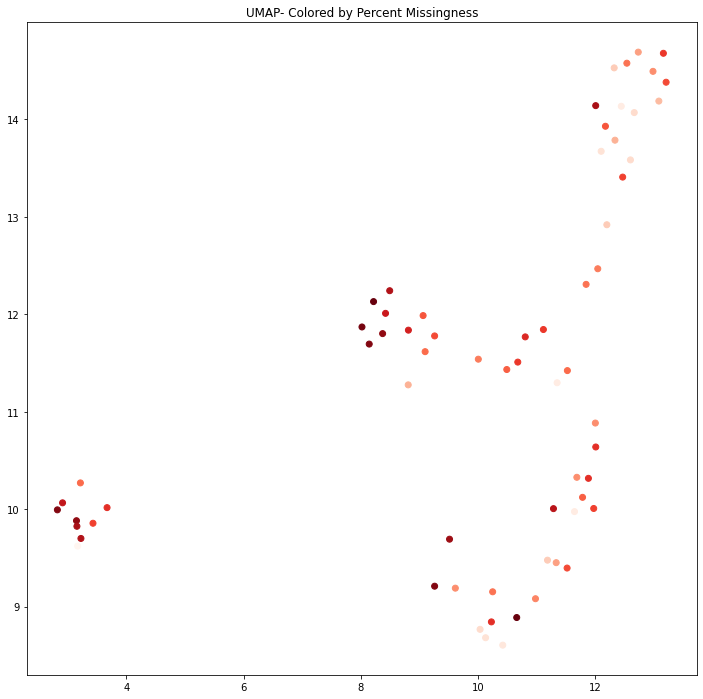

In [9]:
MAP='brg'
plt.figure(figsize = (12,12))
plt.scatter(my_data[:,0], my_data[:,1], c=percent_missing, cmap='Reds')
plt.get_cmap(MAP)
plt.title('UMAP- Colored by Percent Missingness')

Text(0.5, 1.0, 'UMAP- Colored by Variance')

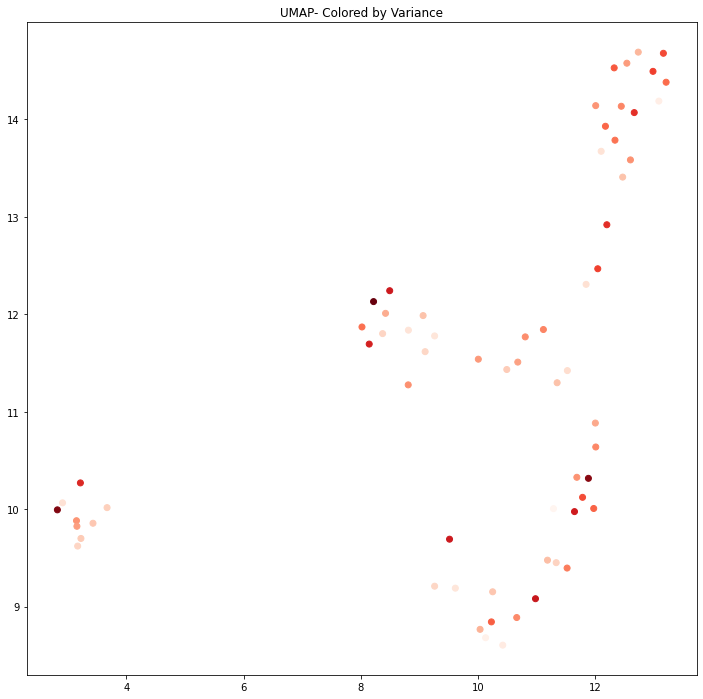

In [10]:
MAP='brg'
plt.figure(figsize = (12,12))
plt.scatter(my_data[:,0], my_data[:,1], c=all_var, cmap='Reds')
plt.get_cmap(MAP)
plt.title('UMAP- Colored by Variance')

Text(0.5, 1.0, 'UMAP- Colored by Mean of Anxiety Data')

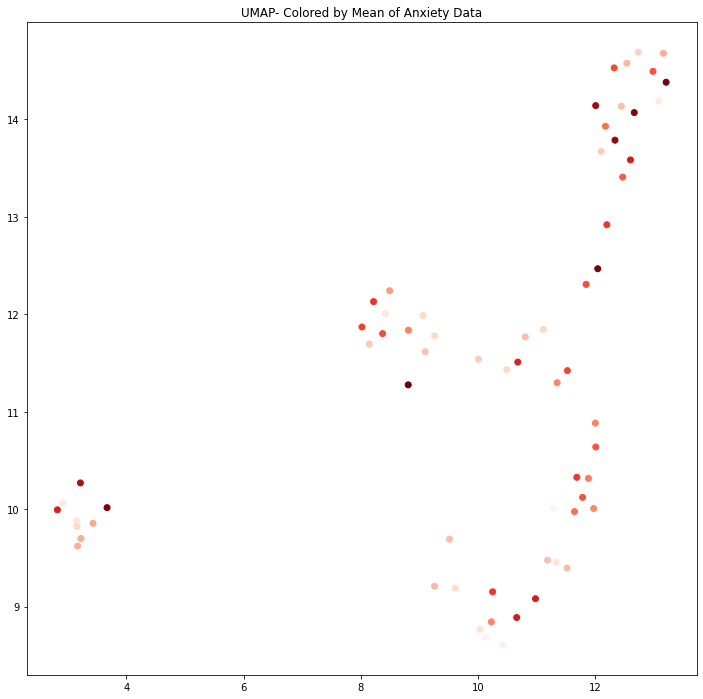

In [11]:
MAP='brg'
plt.figure(figsize = (12,12))
plt.scatter(my_data[:,0], my_data[:,1], c=mean, cmap='Reds')
plt.get_cmap(MAP)
plt.title('UMAP- Colored by Mean of Anxiety Data')

## Hierarchical Clustering Analysis

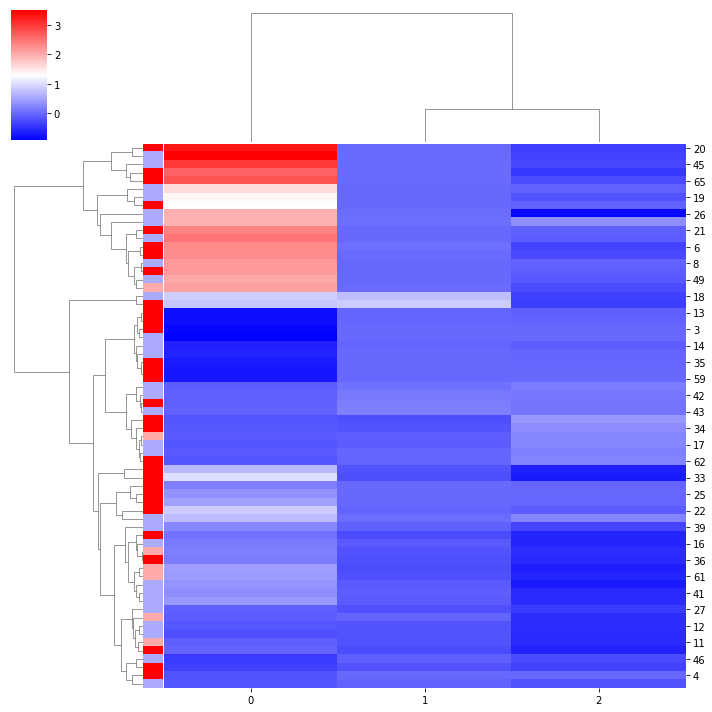

In [12]:
# Hierarchical Clustering colored by GAD-7 score 

import matplotlib.cm as cm
import matplotlib

labels = GAD_outcome_binned

minima = min(labels)
maxima = max(labels)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip = True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

row_colors = []
for v in labels:
    row_colors.append(mapper.to_rgba(v))

sns.clustermap(pd.DataFrame(output_feature), row_colors=row_colors, cmap = 'bwr')